In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
from tqdm import tnrange, tqdm_notebook

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 7
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  7
Current device:  7


In [4]:
DATA_PATH = '../../data/mercado-livre-pt-only'
TRAIN_DATASET = os.path.join(DATA_PATH, 'train.csv')
VAL_DATASET = os.path.join(DATA_PATH, 'val.csv')
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [13]:
LM_PATH=Path('../../models/ulmfit/lm/tweets-pt-pmann/')
LM_PATH.mkdir(exist_ok=True)

In [14]:
def read_data(filename):
    data = pd.read_csv(filename, sep=",", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [15]:
train_dataset = read_data(TRAIN_DATASET).dropna()
val_dataset = read_data(VAL_DATASET).dropna()
test_dataset = read_data(TEST_DATASET).dropna()

In [16]:
train_dataset.head()

,utterance,label
0,cabo fio de aco pesca flexivel marine sports 9...,FISHING_LINES
1,carregador motorola turbo original moto x play...,MOBILE_DEVICE_CHARGERS
2,oculos masculino feminino protecao solar grand...,SUNGLASSES
3,freezer consul fre descongelamento automatic...,FREEZERS
4,roda i30 - aro 17 original,CAR_WHEELS


In [17]:
tokenizer = Tokenizer(lang='pt', n_cpus=10)

In [19]:
data_lm = TextLMDataBunch.from_df(LM_PATH, train_df = train_dataset, valid_df = val_dataset,  bs=128, text_cols=0)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [20]:
data_lm.save('data_lm_mercado_livre_pt_only')

In [ ]:
#data_lm = load_data(LM_PATH, 'data_lm_mercado_livre_pt_only', bs=128)

In [21]:
weights_pretrained = 'tweets-pt-30k-pmann-reduced-lm-step2-best'
itos_pretrained = 'tweets_pt_lm_pmann_reduced_30k_itos_vocab'
pretained_data = (weights_pretrained, itos_pretrained)

In [23]:
!find ../../../ -name tweets-pt-30k-pmann-reduced-lm-step2-best*

../../../organized/models/ulmfit/lm/tweets-pt-pmann/models/tweets-pt-30k-pmann-reduced-lm-step2-best.pth


In [19]:
#!cp ../../data/twitter-pt/models/tweets-pt-25k-lm-step2-best.pth ../../models/ulmfit/lm/mercado-livre-pt-only/models/

In [24]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretained_data, drop_mult=0, callback_fns=ShowGraph)
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 9.12E-02


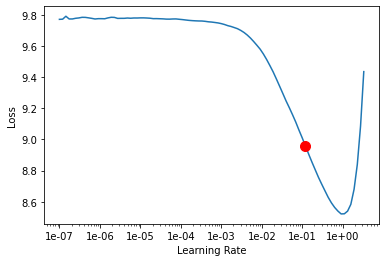

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,4.915710,4.822452,0.256993,03:25
1,4.750849,4.684961,0.264711,03:26
2,4.418758,4.446529,0.283500,03:27
3,4.014153,4.216088,0.304770,03:26
4,3.703654,4.154694,0.312790,03:26


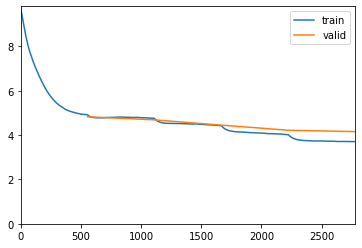

Better model found at epoch 0 with valid_loss value: 4.822451591491699.
Better model found at epoch 1 with valid_loss value: 4.684961318969727.
Better model found at epoch 2 with valid_loss value: 4.446528911590576.
Better model found at epoch 3 with valid_loss value: 4.21608829498291.
Better model found at epoch 4 with valid_loss value: 4.154694080352783.


In [26]:
learn.fit_one_cycle(5, 5e-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-head-best')])

In [27]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-head-best') 

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (498780 items)
x: LMTextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x play - nao e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: LMLabelList
,,,,
Path: ../../models/ulmfit/lm/tweets-pt-pmann;

Valid: LabelList (55420 items)
x: LMTextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: LMLabelList
,,,,
Path: ../../models/ulmfit/lm/tweets-pt-pmann;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)

epoch,train_loss,valid_loss,accuracy,time
0,3.669971,4.092164,0.316583,03:52
1,3.674541,3.995169,0.324336,03:51
2,3.413754,3.883814,0.342175,03:55
3,3.037431,3.844251,0.355010,03:53
4,2.703411,3.921655,0.355611,03:55


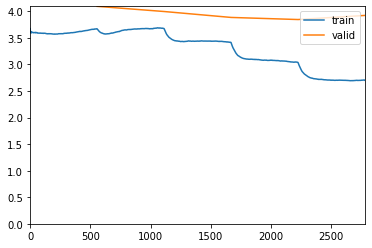

Better model found at epoch 0 with valid_loss value: 4.092164039611816.
Better model found at epoch 1 with valid_loss value: 3.995169162750244.
Better model found at epoch 2 with valid_loss value: 3.8838136196136475.
Better model found at epoch 3 with valid_loss value: 3.8442509174346924.


In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, 8E-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-step2-best')])

In [29]:
np.exp(3.921655)

50.48392657630633

In [30]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-step2-best')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (498780 items)
x: LMTextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x play - nao e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: LMLabelList
,,,,
Path: ../../models/ulmfit/lm/tweets-pt-pmann;

Valid: LabelList (55420 items)
x: LMTextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: LMLabelList
,,,,
Path: ../../models/ulmfit/lm/tweets-pt-pmann;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)

In [31]:
learn.save_encoder('tweets-pt-30k-FT-mercado_livre_pt_only-encoder')

In [33]:
!cp ../../models/ulmfit/lm/tweets-pt-pmann/models/tweets-pt-30k-FT-mercado_livre_pt_only-encoder.pth models/

In [34]:
learn.predict('intel')

'intel core'

In [35]:
data_class = TextClasDataBunch.from_df(path = "", train_df = train_dataset, valid_df = val_dataset, test_df = test_dataset,  vocab=data_lm.vocab,tokenizer=tokenizer, bs=128, text_cols=['utterance'], label_cols=['label'])

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [37]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.1, callback_fns=ShowGraph)
learn.load_encoder('tweets-pt-30k-FT-mercado_livre_pt_only-encoder')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 5.25E-02


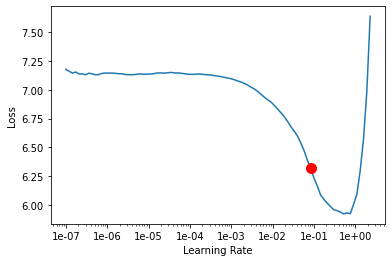

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.840023,0.726727,0.839372,01:27
1,1.019113,0.842683,0.815175,01:26
2,1.142233,0.973696,0.796030,01:26
3,1.108964,0.950852,0.793811,01:27
4,1.023415,0.866298,0.807163,01:27
5,0.892283,0.738210,0.837784,01:31
6,0.854664,0.655147,0.851859,01:28
7,0.643700,0.547809,0.875821,01:27
8,0.580400,0.461742,0.894803,01:30
9,0.501537,0.428152,0.903843,01:29


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


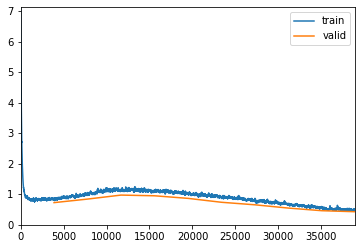

Better model found at epoch 0 with valid_loss value: 0.7267267107963562.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

Better model found at epoch 6 with valid_loss value: 0.6551471948623657.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 7 with valid_loss value: 0.5478091835975647.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 8 with valid_loss value: 0.4617418646812439.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 9 with valid_loss value: 0.42815232276916504.


In [39]:
learn.fit_one_cycle(10, 1E-1, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-classifier-head-best')])

In [40]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-classifier-head-best')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (498780 items)
x: TextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x xxunk e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: CategoryList
FISHING_LINES,MOBILE_DEVICE_CHARGERS,SUNGLASSES,FREEZERS,CAR_WHEELS
Path: .;

Valid: LabelList (55420 items)
x: TextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: CategoryList
BASS_GUITARS,VIDEO_GAMES,TABLETS,TELEVISIONS,DIGITAL_VOICE_RECORDERS
Path: .;

Test: LabelList (138550 items)
x: TextList
xxbos bandeja decorativa - xxunk cm - xxunk,xxbos jogo de molas esportiva jj megane grand tour 1.6 20

epoch,train_loss,valid_loss,accuracy,time
0,0.770210,0.656844,0.867629,01:39
1,0.363835,0.341664,0.927102,01:36


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


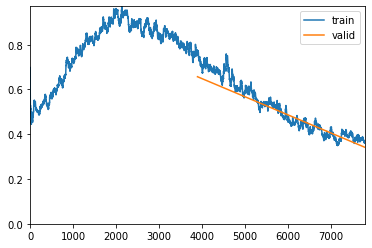

Better model found at epoch 0 with valid_loss value: 0.656844437122345.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.34166380763053894.


In [41]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(7E-2/(2.6**4),7E-2), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step2')])


In [42]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (498780 items)
x: TextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x xxunk e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: CategoryList
FISHING_LINES,MOBILE_DEVICE_CHARGERS,SUNGLASSES,FREEZERS,CAR_WHEELS
Path: .;

Valid: LabelList (55420 items)
x: TextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: CategoryList
BASS_GUITARS,VIDEO_GAMES,TABLETS,TELEVISIONS,DIGITAL_VOICE_RECORDERS
Path: .;

Test: LabelList (138550 items)
x: TextList
xxbos bandeja decorativa - xxunk cm - xxunk,xxbos jogo de molas esportiva jj megane grand tour 1.6 20

epoch,train_loss,valid_loss,accuracy,time
0,0.325560,0.326342,0.930458,02:11
1,0.275595,0.307698,0.933598,02:16
2,0.249140,0.303377,0.935601,02:15
3,0.193470,0.304442,0.936341,02:14


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


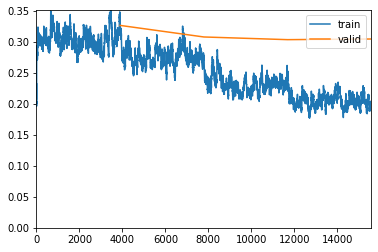

Better model found at epoch 0 with valid_loss value: 0.3263423442840576.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.3076980710029602.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 2 with valid_loss value: 0.3033773601055145.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [43]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step3')])


In [44]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (498780 items)
x: TextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x xxunk e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: CategoryList
FISHING_LINES,MOBILE_DEVICE_CHARGERS,SUNGLASSES,FREEZERS,CAR_WHEELS
Path: .;

Valid: LabelList (55420 items)
x: TextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: CategoryList
BASS_GUITARS,VIDEO_GAMES,TABLETS,TELEVISIONS,DIGITAL_VOICE_RECORDERS
Path: .;

Test: LabelList (138550 items)
x: TextList
xxbos bandeja decorativa - xxunk cm - xxunk,xxbos jogo de molas esportiva jj megane grand tour 1.6 20

epoch,train_loss,valid_loss,accuracy,time
0,0.311097,0.327514,0.930242,03:10
1,0.255894,0.325664,0.933923,03:13
2,0.160619,0.302773,0.940292,03:11
3,0.097636,0.302364,0.941790,03:16


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


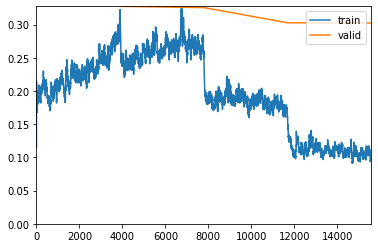

Better model found at epoch 0 with valid_loss value: 0.32751384377479553.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.3256635069847107.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 2 with valid_loss value: 0.3027734160423279.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 3 with valid_loss value: 0.3023642897605896.


In [45]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step4')])

In [46]:
learn.load('tweets-pt-30k-FT-mercado_livre_pt_only-classifier-step4')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (498780 items)
x: TextList
xxbos cabo fio de aco pesca flexivel marine sports 90lbs - 10 m,xxbos carregador motorola turbo original moto x xxunk e replica,xxbos oculos masculino feminino protecao solar grande mestre 2018,xxbos freezer consul fre xxunk automatico 6 gavetas e,xxbos roda i30 - aro 17 original
y: CategoryList
FISHING_LINES,MOBILE_DEVICE_CHARGERS,SUNGLASSES,FREEZERS,CAR_WHEELS
Path: .;

Valid: LabelList (55420 items)
x: TextList
xxbos contrabaixo 4c fender squier affinity j bass - 532 - brown s,xxbos warriors orochi 3 ultimate - ps4 - midia fisica lacrado,xxbos capa tablet lenovo tab3 8 ( 850f ) - varias cores,xxbos tv xxunk,xxbos gravador de voz com sensor presenca avancado pequeno bb1
y: CategoryList
BASS_GUITARS,VIDEO_GAMES,TABLETS,TELEVISIONS,DIGITAL_VOICE_RECORDERS
Path: .;

Test: LabelList (138550 items)
x: TextList
xxbos bandeja decorativa - xxunk cm - xxunk,xxbos jogo de molas esportiva jj megane grand tour 1.6 20

In [47]:
y = []
for item in test_dataset.itertuples():
    label = item[2]
    label_id = learn.data.classes.index(label)
    y.append(label_id)

In [48]:
preds_test = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [49]:
y_hat = torch.argmax(preds_test[0], dim=1)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y, y_hat, target_names=learn.data.classes, digits=3))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                             precision    recall  f1-score   support

                                3D_PRINTERS      1.000     0.979     0.989        47
                                ABS_SENSORS      0.978     0.957     0.968       140
                           AB_ROLLER_WHEELS      1.000     0.900     0.947        10
                                 ACCORDIONS      0.978     0.981     0.979       311
                            ACOUSTIC_PANELS      1.000     0.778     0.875         9
                             ACTION_FIGURES      0.732     0.735     0.734       800
                             ADHESIVE_TAPES      0.972     0.957     0.964       253
                                AFTERSHAVES      0.000     0.000     0.000         3
                                    AIRBAGS      0.925     0.881     0.902        42
                             AIRBAG_MODULES      1.000     0.667     0.800         3
                                 AIRBRUSHES      1.000     0.750

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
